In [2]:
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle


### Another Way of Growing Trees

In [3]:
xgb_model_3 = xgb.XGBClassifier(n_estimators = 1000, max_depth = 0, learning_rate = 0.1, 
                verbosity = 1, objective = 'binary:logistic', use_label_encoder = False, n_jobs = -1, tree_method = 'hist', grow_policy = 'lossguide')

In [4]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples = 5000, n_features = 40, n_informative = 3, 
            n_redundant  = 2, n_classes = 2, n_repeated = 0, n_clusters_per_class = 3, weights = None, flip_y = 0.05, class_sep = 0.1, hypercube = True, shift = 0.0, scale = 1.0, shuffle = True, random_state = 2)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 24)

In [6]:
max_leaves_values = list(range(5, 105, 5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[80, 85, 90, 95, 100]


In [7]:
fit_params = {
    'verbose': False,
    'eval_set':[(X_train, y_train),(X_val, y_val)],
    
}
set_fit_params = {
    'eval_metric':'auc',
    'early_stopping_rounds':30
}

In [8]:
from sklearn.metrics import roc_auc_score as ras

In [9]:

%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model_3.set_params(**{'max_leaves':max_leaves})
    xgb_model_3.set_params(**set_fit_params)
    xgb_model_3.fit(X_train, y_train, **fit_params)
    #Get validation score
    val_set_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
    val_aucs.append(ras(y_val, val_set_pred_proba))
    

c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core

CPU times: total: 1min 52s
Wall time: 41.4 s


In [10]:
max_leaves_df = pd.DataFrame({'Max Leaves':max_leaves_values, 'Validation AUC':val_aucs})

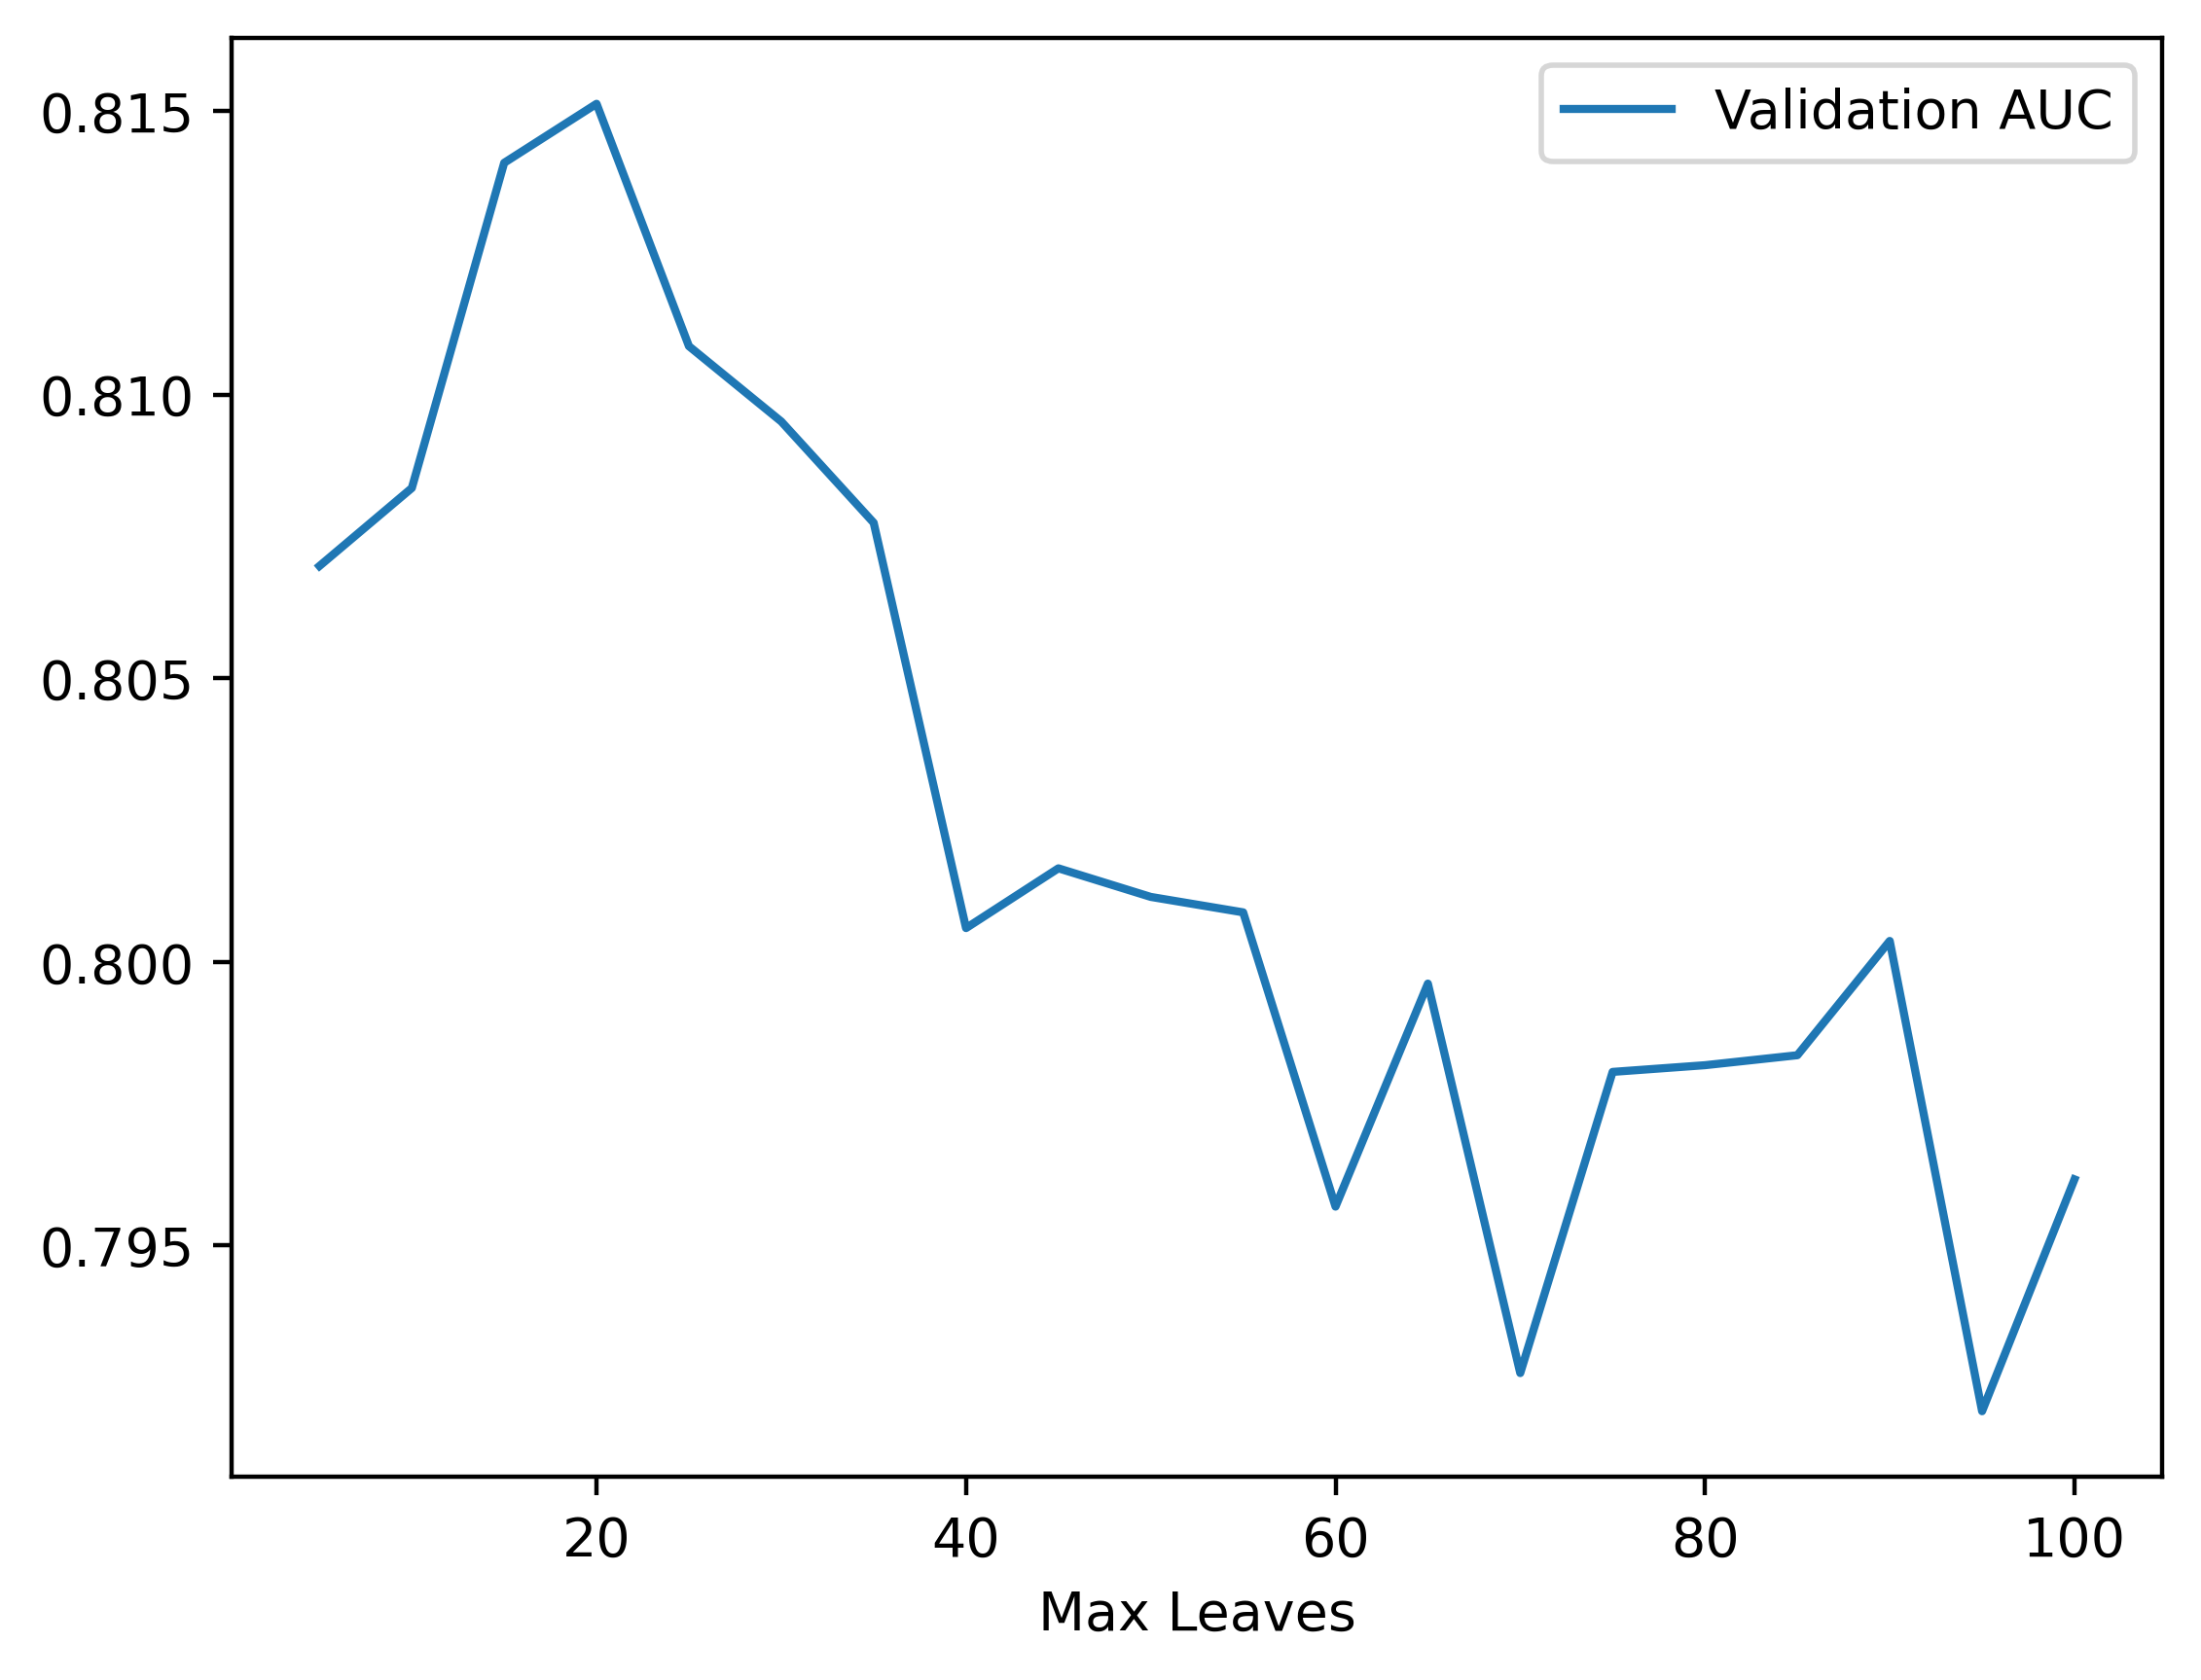

In [11]:
mpl.rcParams['figure.dpi'] = 400
max_leaves_df.set_index('Max Leaves').plot()
plt.show()

In [12]:
max_auc = max_leaves_df['Validation AUC'].max()
max_auc

0.8151281015048877

In [13]:
max_ix = max_leaves_df['Validation AUC'] == max_auc
max_leaves_df[max_ix]

,Max Leaves,Validation AUC
3,20,0.815128


#### Explaining model predictions with SHAP Values

In [14]:
%%time
xgb_model_3.set_params(**{'max_leaves':20})
xgb_model_3.set_params(**set_fit_params)
xgb_model_3.fit(X_train, y_train, **fit_params)

c:\Users\HI\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: total: 2.38 s
Wall time: 2.88 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=20,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
X_val.shape

(1000, 40)

In [16]:
feature_names = ['Feature {number}'.format(number = number) for number in range(X_val.shape[1])]
X_val_df = pd.DataFrame(data = X_val, columns = feature_names)
X_val_df.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39
0,1.852885,-2.170293,1.057288,0.441873,-0.803131,-0.025139,-0.037143,0.037565,1.163995,0.678410,...,-0.592176,0.529113,0.923351,0.511203,-0.390155,-0.142262,0.760561,-0.421488,1.770300,-0.292780
1,-0.818316,-1.126948,0.647810,0.092433,-1.030356,0.754323,-0.351566,-0.523476,1.144878,0.219172,...,0.545090,1.125089,0.848158,-0.870549,-1.094581,-1.480010,-2.444469,0.905715,-1.008522,1.537315
2,0.020271,-0.758004,-1.136195,0.473366,1.291465,0.890423,-2.217706,-2.030749,1.768624,-2.106202,...,-0.741205,-0.833958,-0.265291,-1.021137,0.247897,-0.058583,0.445473,0.349382,0.208958,0.252826
3,-0.271543,-0.366639,-1.139614,-0.753586,1.427853,1.249856,0.060528,-0.374193,0.047770,0.640638,...,-0.539878,0.569599,0.508334,-0.513756,0.769438,1.100097,0.682759,0.888623,-0.464301,-1.125279
4,-0.549078,0.494648,-1.266778,-0.292728,1.459779,0.497898,-0.618724,-1.225373,0.171507,0.833027,...,-0.366978,-0.308615,0.838910,0.208853,2.517458,0.471553,0.982017,0.030594,0.449982,-0.670582


In [17]:
explainer = shap.explainers.Tree(xgb_model_3, data = X_val_df)

In [18]:
shap_values = explainer(X_val_df)
shap_values.values.shape

(1000, 40)

In [19]:
mpl.rcParams['figure.dpi'] = 75

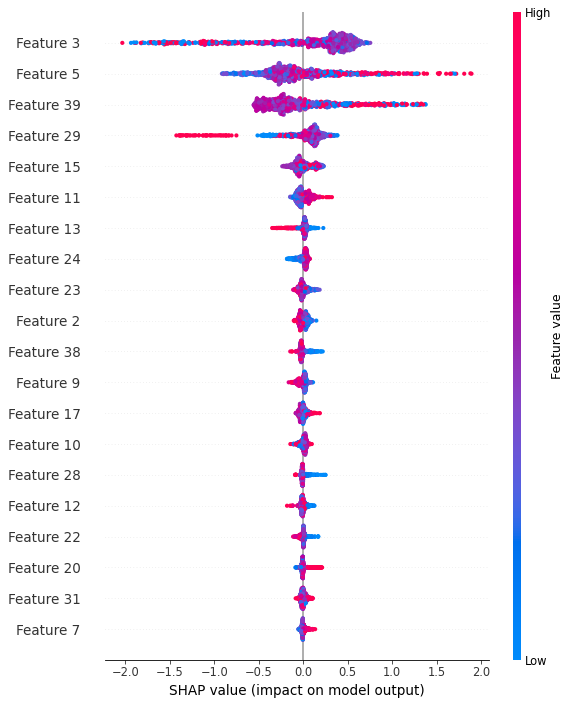

In [20]:
shap.summary_plot(shap_values.values, X_val_df)

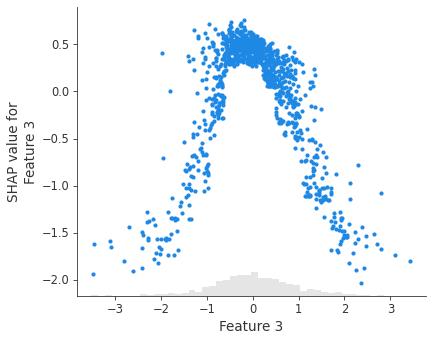

In [21]:
shap.plots.scatter(shap_values[:,'Feature 3'])

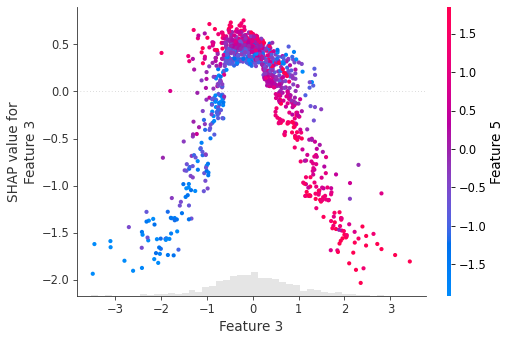

In [22]:
shap.plots.scatter(shap_values[:,'Feature 3'], color = shap_values[:,'Feature 5'])

 ##### Plotting SHAP Interactions, Feature Importance, and Reconstructing Predicted Probabilities from SHAP Values

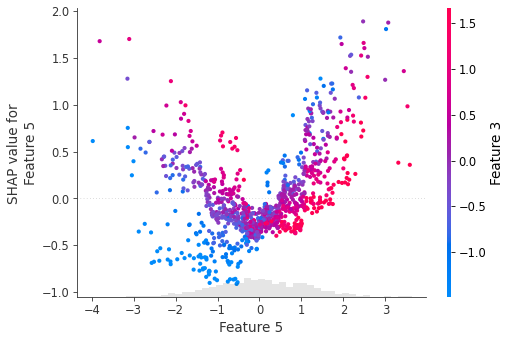

In [23]:
shap.plots.scatter(shap_values[:,'Feature 5'], color = shap_values[:,'Feature 3'])

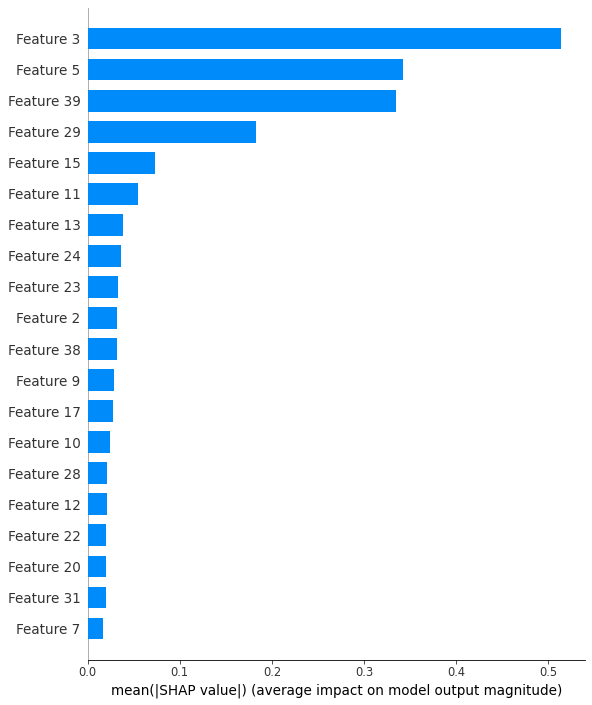

In [24]:
shap.summary_plot(shap_values.values, X_val, plot_type = "bar")


In [25]:
explainer.expected_value

-0.051564168616492816

In [26]:
shap_sum = shap_values.values.sum(axis = 1) + explainer.expected_value
shap_sum.shape

(1000,)

In [27]:
shap_sum_prob = 1/(1+np.exp(-1*shap_sum))
shap_sum_prob.shape

(1000,)

In [28]:
y_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
y_pred_proba.shape

(1000,)

In [29]:
df_check = pd.DataFrame({'SHAP sum':shap_sum_prob, 'Predicted probability': y_pred_proba})
df_check.sample(5, random_state = 1)

,SHAP sum,Predicted probability
507,0.497253,0.497253
818,0.466154,0.466154
452,0.881365,0.881365
368,0.145359,0.145359
242,0.481085,0.481085


In [30]:
np.allclose(df_check['SHAP sum'], df_check['Predicted probability'])

True

In [31]:
np.array_equal(df_check['SHAP sum'], df_check['Predicted probability'])

False

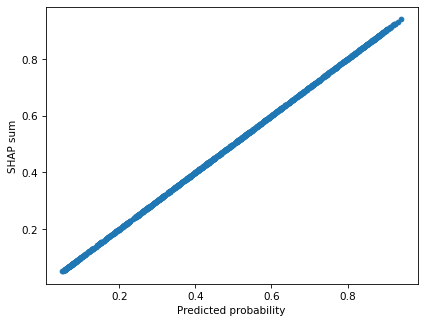

In [32]:
df_check.plot.scatter(x='Predicted probability', y='SHAP sum')
plt.show()

In [34]:
# Define the variables
features_response = ['Feature {number}'.format(number=number) for number in range(X.shape[1])]
X_train_all = X_train
y_train_all = y_train
x_test_all = X_val
y_test_all = y_val

# Save the variables to a pickle file
with open('CaseStudyFile/Data/Chapter_1_cleaned_data.pkl', "wb") as f:
    pickle.dump([features_response, X_train_all, y_train_all, x_test_all, y_test_all], f)